---
author: Zeel B Patel
badges: true
categories: ML
description: Exploring the use of GPs for climate modeling
title: Climate Modeling with GPs
date: '2023-07-04'
toc: true
---

In [138]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import pyproj
import numpy as np
import xarray as xr

from skgpytorch.models import GPRegression

import matplotlib.pyplot as plt

In [139]:
# def haversine(lon1, lat1, lon2, lat2):
#     """
#     Calculate the great circle distance in kilometers between two points 
#     on the earth (specified in decimal degrees)
#     """
#     # convert decimal degrees to radians 
#     lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

#     # haversine formula 
#     dlon = lon2 - lon1 
#     dlat = lat2 - lat1 
#     a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
#     c = 2 * np.arcsin(np.sqrt(a)) 
#     r = 6371 # Radius of earth in kilometers. Use 3956 for miles. Determines return value units.
#     return c * r

# def new_coords(lat1, long1):
#     new_lat1 = haversine(0, 0, 0, lat1)
#     new_long1 = haversine(0, 0, long1, 0)
#     return new_lat1, new_long1

def lat_long_to_cartesian(latitude, longitude):
    # Convert latitude and longitude to radians
    phi = np.radians(latitude)
    lam = np.radians(longitude)

    # Constants for WGS 84 ellipsoid
    a = 6378137.0  # equatorial radius in meters
    e = 0.0818191908426  # eccentricity

    # Calculate Earth's radius at the given latitude
    R = a / np.sqrt(1 - (e ** 2) * (np.sin(phi) ** 2))

    # Convert to Cartesian coordinates
    X = R * np.sin(lam)
    Y = R * np.tan(phi)

    return X, Y

def wgs84_coords(lat, lon):    
    # Define coordinate systems
    wgs84 = pyproj.CRS.from_epsg(4326)  # WGS 84 lat-long system
    utm_zone_32n = pyproj.CRS.from_string("+proj=utm +zone=32 +ellps=WGS84 +datum=WGS84 +units=m +no_defs")

    # Create a transformer object
    transformer = pyproj.Transformer.from_crs(wgs84, utm_zone_32n)

    # Convert lat-long coordinates to UTM coordinates
    utm_easting, utm_northing = transformer.transform(lon, lat)

    return utm_northing, utm_easting

# Copyright (c) Meta Platforms, Inc. and affiliates.
# All rights reserved.

# This source code is licensed under the license found in the
# LICENSE file in the root directory of this source tree.
# --------------------------------------------------------
# Position embedding utils
# --------------------------------------------------------


# --------------------------------------------------------
# 2D sine-cosine position embedding
# References:
# Transformer: https://github.com/tensorflow/models/blob/master/official/nlp/transformer/model_utils.py
# MoCo v3: https://github.com/facebookresearch/moco-v3
# --------------------------------------------------------
def get_2d_sincos_pos_embed(embed_dim, grid_size_h, grid_size_w, cls_token=False):
    """
    grid_size: int of the grid height and width
    return:
    pos_embed: [grid_size*grid_size, embed_dim] or [1+grid_size*grid_size, embed_dim] (w/ or w/o cls_token)
    """
    grid_h = np.arange(grid_size_h, dtype=np.float32)
    grid_w = np.arange(grid_size_w, dtype=np.float32)
    grid = np.meshgrid(grid_w, grid_h)  # here w goes first
    grid = np.stack(grid, axis=0)

    grid = grid.reshape([2, 1, grid_size_h, grid_size_w])
    pos_embed = get_2d_sincos_pos_embed_from_grid(embed_dim, grid)
    if cls_token:
        pos_embed = np.concatenate([np.zeros([1, embed_dim]), pos_embed], axis=0)
    return pos_embed


def get_2d_sincos_pos_embed_from_grid(embed_dim, grid):
    assert embed_dim % 2 == 0

    # use half of dimensions to encode grid_h
    emb_h = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[0])  # (H*W, D/2)
    emb_w = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[1])  # (H*W, D/2)

    emb = np.concatenate([emb_h, emb_w], axis=1)  # (H*W, D)
    return emb


def get_1d_sincos_pos_embed_from_grid(embed_dim, pos):
    """
    embed_dim: output dimension for each position
    pos: a list of positions to be encoded: size (M,)
    out: (M, D)
    """
    assert embed_dim % 2 == 0
    omega = np.arange(embed_dim // 2, dtype=np.float)
    omega /= embed_dim / 2.0
    omega = 1.0 / 10000**omega  # (D/2,)

    pos = pos.reshape(-1)  # (M,)
    out = np.einsum("m,d->md", pos, omega)  # (M, D/2), outer product

    emb_sin = np.sin(out)  # (M, D/2)
    emb_cos = np.cos(out)  # (M, D/2)

    emb = np.concatenate([emb_sin, emb_cos], axis=1)  # (M, D)
    return emb


# --------------------------------------------------------
# Interpolate position embeddings for high-resolution
# References:
# DeiT: https://github.com/facebookresearch/deit
# --------------------------------------------------------
def interpolate_pos_embed(model, checkpoint_model, new_size=(64, 128)):
    if "net.pos_embed" in checkpoint_model:
        pos_embed_checkpoint = checkpoint_model["net.pos_embed"]
        embedding_size = pos_embed_checkpoint.shape[-1]
        orig_num_patches = pos_embed_checkpoint.shape[-2]
        patch_size = model.patch_size
        w_h_ratio = 2
        orig_h = int((orig_num_patches // w_h_ratio) ** 0.5)
        orig_w = w_h_ratio * orig_h
        orig_size = (orig_h, orig_w)
        new_size = (new_size[0] // patch_size, new_size[1] // patch_size)
        # print (orig_size)
        # print (new_size)
        if orig_size[0] != new_size[0]:
            print("Interpolate PEs from %dx%d to %dx%d" % (orig_size[0], orig_size[1], new_size[0], new_size[1]))
            pos_tokens = pos_embed_checkpoint.reshape(-1, orig_size[0], orig_size[1], embedding_size).permute(
                0, 3, 1, 2
            )
            new_pos_tokens = torch.nn.functional.interpolate(
                pos_tokens, size=(new_size[0], new_size[1]), mode="bicubic", align_corners=False
            )
            new_pos_tokens = new_pos_tokens.permute(0, 2, 3, 1).flatten(1, 2)
            checkpoint_model["net.pos_embed"] = new_pos_tokens


def interpolate_channel_embed(checkpoint_model, new_len):
    if "net.channel_embed" in checkpoint_model:
        channel_embed_checkpoint = checkpoint_model["net.channel_embed"]
        old_len = channel_embed_checkpoint.shape[1]
        if new_len <= old_len:
            checkpoint_model["net.channel_embed"] = channel_embed_checkpoint[:, :new_len]

In [140]:
def SIREN(input_dim, output_dim, features, activation_scale, dropout):
    model = tf.keras.Sequential()
    model.add(layers.Dense(features[0], input_shape=(input_dim,), kernel_initializer=initializers.RandomUniform(-1 / input_dim, 1 / input_dim), activation=tf.sin))
    for i in range(1, len(features)):
        model.add(layers.Dense(features[i], kernel_initializer=initializers.RandomUniform(-np.sqrt(6 / features[i-1]) / activation_scale, np.sqrt(6 / features[i-1]) / activation_scale), activation=tf.sin))
        model.add(layers.Dropout(dropout))
    model.add(layers.Dense(output_dim, kernel_initializer=initializers.RandomUniform(-np.sqrt(6 / features[-1]) / activation_scale, np.sqrt(6 / features[-1]) / activation_scale), activation='linear'))
    return model

def MLP(input_dim, output_dim, features, activation_scale, dropout):
    model = tf.keras.Sequential()
    model.add(layers.Dense(features[0], input_shape=(input_dim,), activation=activations.relu))
    for i in range(1, len(features)):
        model.add(layers.Dense(features[i], activation=activations.relu))
        model.add(layers.Dropout(dropout))
    model.add(layers.Dense(output_dim, activation='linear'))
    return model
    
def ResNet():
    resnet = ResNet50(include_top=False, weights=None, input_shape=(64, 32, 1), pooling='avg')
    model = tf.keras.Sequential()
    model.add(resnet)
    model.add(layers.Dense(2048, activation='relu'))
    model.add(layers.Dense(32768, activation='linear'))
    return model

In [141]:
data5 = xr.open_dataset("../data/2m_temperature_2018_5.625deg_Jan.nc").to_dataframe().reset_index()
data1 = xr.open_dataset("../data/2m_temperature_2018_1.40625deg_Jan.nc").to_dataframe().reset_index()

In [167]:
data5.head()

,lon,lat,time,t2m
0,0.0,-87.1875,2018-01-01 00:00:00,250.728180
1,0.0,-87.1875,2018-01-01 01:00:00,250.468552
2,0.0,-87.1875,2018-01-01 02:00:00,250.250931
3,0.0,-87.1875,2018-01-01 03:00:00,250.040314
4,0.0,-87.1875,2018-01-01 04:00:00,249.993790


In [142]:
time_stamp = "2018-01-01 01:00:00"
train_df = data5[data5.time == time_stamp]
test_df = data1[data1.time == time_stamp]

X = np.stack([train_df.lat.values, train_df.lon.values], axis=1)
y = train_df[["t2m"]].values
print(f"{X.shape=}, {y.shape=}")

X_test = np.stack([test_df.lat.values, test_df.lon.values], axis=1)
y_test = test_df[["t2m"]].values
print(f"{X_test.shape=}, {y_test.shape=}")

rff = np.random.normal(size=(2, 16)) * 0.01
# X = np.concatenate([np.sin(X @ rff), np.cos(X @ rff)], axis=1)
# print(f"{sin_cos.shape=}")
# X = X @ sin_cos
# X_test = np.concatenate([np.sin(X_test @ rff), np.cos(X_test @ rff)], axis=1)

print(f"{X.shape=}, {X_test.shape=}")

X.shape=(2048, 2), y.shape=(2048, 1)
X_test.shape=(32768, 2), y_test.shape=(32768, 1)
X.shape=(2048, 2), X_test.shape=(32768, 2)


In [143]:
X_max = np.max(X, axis=0, keepdims=True)
X_min = np.min(X, axis=0, keepdims=True)

X_scaled = (X - X_min) / (X_max - X_min)
X_test_scaled = (X_test - X_min) / (X_max - X_min)

y_min = np.min(y, axis=0, keepdims=True)
y_max = np.max(y, axis=0, keepdims=True)

y_scaled = (y - y_min) / (y_max - y_min)

# y_mean = np.mean(y, axis=0, keepdims=True)
# y_std = np.std(y, axis=0, keepdims=True)

# y_scaled = (y - y_mean) / y_std

In [144]:
model = MLP(2, 1, [256]*4, 30.0, 0.0)
# model = ResNet()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss='mse')

In [145]:
history = model.fit(X_scaled, y_scaled, epochs=5000, batch_size=X_scaled.shape[0], verbose=0)

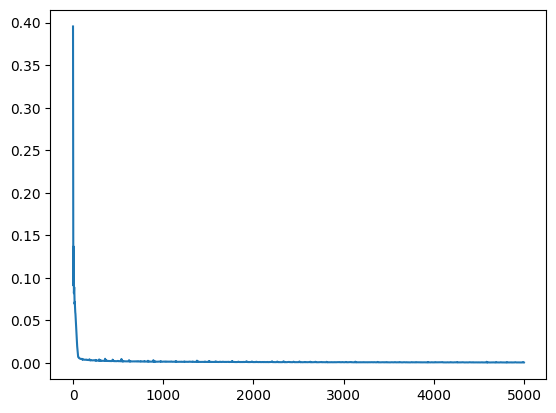

In [147]:
plt.plot(history.history['loss']);

1024/1024 [==============================] - 1s 1ms/step


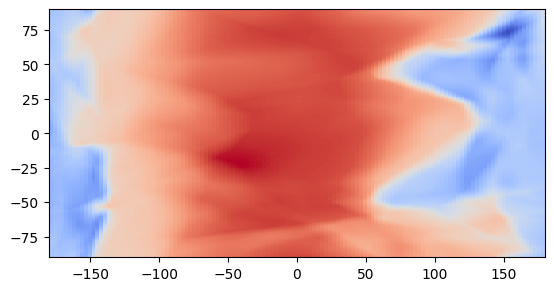

In [148]:
y_pred = model.predict(X_test_scaled) * (y_max - y_min) + y_min
plt.imshow(y_pred.reshape(256, 128), origin='lower', extent=[-180, 180, -90, 90], cmap='coolwarm', interpolation="none");

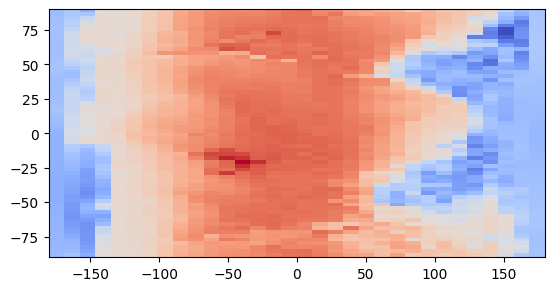

In [149]:
plt.imshow(y.reshape(64, 32), origin='lower', extent=[-180, 180, -90, 90], cmap='coolwarm', interpolation="none");

Text(0.5, 1.0, 'Diff')

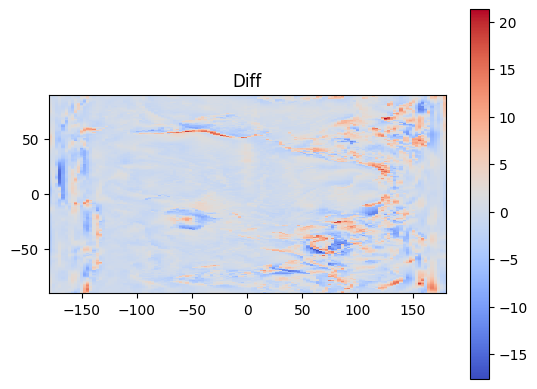

In [150]:
diff = y_pred.reshape(256, 128) - y_test.reshape(256, 128)
plt.imshow(diff, origin='lower', extent=[-180, 180, -90, 90], cmap='coolwarm', interpolation="none");
plt.colorbar();
plt.title("Diff")

In [168]:
# rmse = np.sqrt(np.mean(np.abs(X_test[:, 0:1])*(y_pred.ravel() - y_test.ravel())**2))/np.mean(y_test.ravel() * np.abs(X_test[:, 0:1]))
rmse = np.sqrt(np.mean((y_pred.ravel() - y_test.ravel())**2))
print(f"{rmse=}")

rmse=2.7606046


In [152]:
mean_bias = np.mean(y_pred.ravel() - y_test.ravel())
print(f"{mean_bias=}")

mean_bias=0.10866926
